# Recent supernova

**WARNING**: This notebook will be replaced by a version using the new database, API and client.

Select only fast rising recent supernova, discard candidates too close to the ecliptic or the MW plane, or which have a very large galactic extinction. Also discard candidates which have a high bogus probability (own, or rb or drb)

### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from datetime import datetime
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets
from IPython.core.display import display, HTML

In [2]:
from matplotlib.cm import viridis

ALeRCE client

In [3]:
#!pip install alerce
from alerce.api import AlerceAPI
client = AlerceAPI()

Use pyephem https://pypi.org/project/pyephem/

In [4]:
#!pip install pyephem
import ephem

Install psycopg2 https://github.com/psycopg/psycopg2

In [5]:
#!pip install psycopg2-binary
import psycopg2

In [6]:
import requests

### Get credentials (in github repository)

In [7]:
import json
credentials_file = "../alercereaduser_v2.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

### Connect to DB

In [8]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

### Show all the available tables

In [9]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

,tablename
9,asassn
18,class
10,crtsnorth
12,crtssouth
4,detections
23,early_classification_v2
16,features
22,features_v2
2,features_v3
24,ingestion_timestamp


### For each table, show column names and column types

In [10]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

,table,column_name,data_type
0,asassn,ASAS-SN Name,text
1,asassn,Other Names,text
2,asassn,LCID,integer
3,asassn,ra,double precision
4,asassn,dec,double precision
5,asassn,Mean VMag,double precision
6,asassn,Amplitude,double precision
7,asassn,Period,double precision
8,asassn,Type,text
9,asassn,Url,text


### Query class numbers

In [11]:
query = "select * from class"
classes = pd.read_sql_query(query, conn)
classmapper = dict(zip(classes.name.tolist(), classes.id.tolist()))
classmapper

{'Other': 0,
 'Ceph': 1,
 'LPV': 4,
 'RRL': 5,
 'EB': 3,
 'SNe': 6,
 'DSCT': 2,
 'Blazar': 8,
 'CV/Nova': 9,
 'SLSN': 14,
 'AGN': 18,
 'SN': 19,
 'Variable Star': 20,
 'Asteroid': 21,
 'Bogus': 22,
 'SNIa': 10,
 'SNIbc': 11,
 'SNII': 12,
 'SNIIn': 13,
 'EBSD/D': 15,
 'EBC': 16,
 'Periodic-Other': 17,
 'AGN-I': 7,
 'RS-CVn': 23,
 'QSO-I': 24}

### Query objects which appeared during the last xx days, which are classified as supernova by the early classifier with a probability greater than 0.5 or which have more than one detection

In [12]:
ndays = 10
mjd_last = Time(datetime.utcnow(), scale='utc').mjd - ndays

query='''
select objects.oid, objects.meanra, objects.meandec, objects.firstmjd,
objects.nobs, objects.classearly, objects.pclassearly

from objects

where objects.firstMJD > %s
and objects.classearly=%i
and (objects.pclassearly>0.5 or objects.nobs>1)
''' % (mjd_last, classmapper["SN"])

sn = pd.read_sql_query(query, conn)
sn.set_index('oid', inplace=True)
print(sn.shape)
sn.head()

(388, 6)


,meanra,meandec,firstmjd,nobs,classearly,pclassearly
oid,,,,,,
ZTF20abpcnlf,327.222442,28.794492,59057.369572,1,19,0.565355
ZTF20abppajl,353.140540,44.160650,59060.456586,1,19,0.503240
ZTF20abpskiz,344.674399,12.887192,59061.341447,1,19,0.530261
ZTF20abpvhji,58.250677,45.366985,59061.447720,1,19,0.548145
ZTF20aboyumn,241.628334,27.423567,59057.173866,1,19,0.566397


Text(0.5, 0, 'firstmjd')

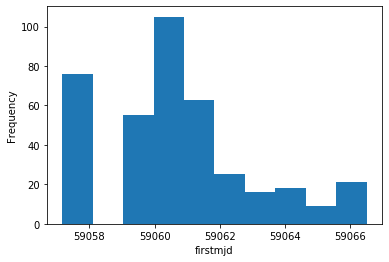

In [13]:
fig, ax = plt.subplots()
sn.firstmjd.plot.hist(ax=ax)
ax.set_xlabel("firstmjd")

### Add early classifier probabilities to sn dataframe

In [14]:
query='''
select oid, sn_prob, vs_prob, agn_prob, asteroid_prob, bogus_prob

from stamp_classification

where oid in (%s)
''' % (",".join(["'%s'" % oid for oid in sn.index]))

early = pd.read_sql_query(query, conn)
early.set_index('oid', inplace=True)
sn = pd.concat([sn, early], axis=1, sort=False)
sn.head()

,meanra,meandec,firstmjd,nobs,classearly,pclassearly,sn_prob,vs_prob,agn_prob,asteroid_prob,bogus_prob
ZTF20abpcnlf,327.222442,28.794492,59057.369572,1,19,0.565355,0.565355,0.088005,0.080903,0.189193,0.076545
ZTF20abppajl,353.140540,44.160650,59060.456586,1,19,0.503240,0.503240,0.084750,0.072371,0.238507,0.101132
ZTF20abpskiz,344.674399,12.887192,59061.341447,1,19,0.530261,0.530261,0.090105,0.097567,0.091925,0.190142
ZTF20abpvhji,58.250677,45.366985,59061.447720,1,19,0.548145,0.548145,0.097364,0.113739,0.130555,0.110197
ZTF20aboyumn,241.628334,27.423567,59057.173866,1,19,0.566397,0.566397,0.067461,0.068460,0.231481,0.066201


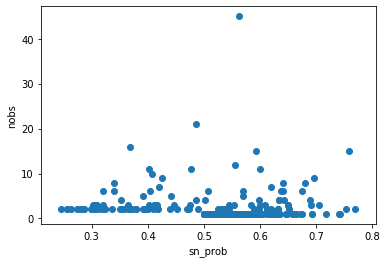

In [15]:
fig, ax = plt.subplots()
ax.set_xlabel("sn_prob")
ax.set_ylabel("nobs")
ax.scatter(sn.sn_prob, sn.nobs)

### Refine search, get first detections if not close to a star and not a bogus according to rb

In [16]:
query='''
select detections.oid, detections.candid,
detections.sgscore1, detections.distpsnr1, detections.rb,
detections.fid, detections.mjd, detections.magpsf, detections.sigmapsf,
detections.has_stamps

from detections

where (detections.sgscore1 < 0.5 or detections.distpsnr1 > 1)
and detections.rb > 0.5
and detections.oid in (%s)
''' % (",".join(["'%s'" % oid for oid in sn.index]))

detections = pd.read_sql_query(query, conn)
detections.set_index('oid', inplace=True)
detections.head()

,candid,sgscore1,distpsnr1,rb,fid,mjd,magpsf,sigmapsf,has_stamps
oid,,,,,,,,,
ZTF20aboytyf,1303175283215015008,0.029375,2.395448,0.798571,2,59057.175289,18.571936,0.125855,True
ZTF20aboytzr,1303175284015015004,0.038458,2.155097,0.887143,2,59057.175289,19.030527,0.116298,True
ZTF20abogugm,1303176221215015011,0.003750,15.456092,0.708571,2,59057.176227,19.887396,0.148125,True
ZTF20aboytzr,1303246574015015005,0.038458,2.199055,0.942857,1,59057.246574,18.927486,0.089295,True
ZTF20abnrbap,1303257104415015004,0.156179,0.850903,0.961429,1,59057.257107,19.489353,0.122486,True


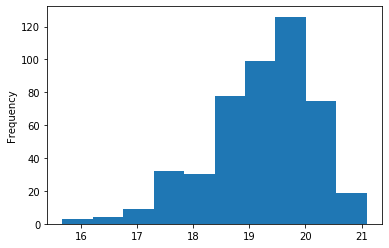

In [17]:
detections.magpsf.plot.hist()

### Get non detections after previous filtering

In [18]:
query='''
select non_detections.oid, 
non_detections.mjd, non_detections.diffmaglim, non_detections.fid

from non_detections

where non_detections.oid in (%s)
''' % (",".join(["'%s'" % oid for oid in detections.index.unique()]))

non_detections = pd.read_sql_query(query, conn)
non_detections.set_index('oid', inplace=True)
non_detections.head()

,mjd,diffmaglim,fid
oid,,,
ZTF20abogugm,59028.243518,20.453800,2
ZTF20abogugm,59028.243993,20.364700,2
ZTF20abogugm,59031.233218,20.015301,2
ZTF20abogugm,59033.247199,19.719999,1
ZTF20abogugm,59034.197882,19.834400,1


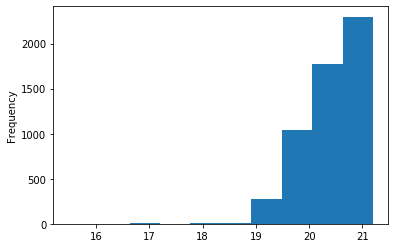

In [19]:
non_detections.diffmaglim.plot.hist()

### Compute dm/dt

In [20]:
def do_dmdt(oid):
    dmdts = []
    dets = detections.loc[oid]
    try: # make sure this is a dataframe and not a series (when only one element)
        dets = dets.to_frame().transpose()
    except:
        True 
    non_dets = non_detections.loc[oid]
    try: # make sure this is a dataframe and not a series (when only one element)
        non_dets = non_dets.to_frame().transpose()
    except:
        True 
    for fid in sorted(dets.fid.unique()):
        if fid == 1:
            fid_str = "g"
        elif fid == 2:
            fid_str = "r"
        else:
            continue
        mask_det = (dets.fid == fid)
        idx_1st_det = dets.loc[mask_det].mjd.astype(float).idxmin()
        mask_non_det = (non_dets.mjd < float(sn.loc[oid].firstmjd)) & (non_dets.fid == fid)
        if mask_non_det.sum() >= 1: # filter must be in both dets and non_dets
            dm = np.array(dets.loc[idx_1st_det].magpsf - non_dets.loc[mask_non_det].diffmaglim)
            dm_error = np.array(dets.loc[idx_1st_det].magpsf + dets.loc[idx_1st_det].sigmapsf - non_dets.loc[mask_non_det].diffmaglim)
            dt = np.array(dets.loc[idx_1st_det].mjd - non_dets.loc[mask_non_det].mjd)
            dmdt = dm/dt
            dmdt_error = dm_error/dt
            idx_dmdt = np.argmin(dmdt_error) #dmdt = (dm/dt).min()                                                                                                                                         
            dmdt_min = dmdt[idx_dmdt]
            dmdt_error_min = dmdt_error[idx_dmdt]
            newdf = pd.DataFrame(data = {"dmdt_min": [dmdt_min], "dmdt_error": [dmdt_error_min - dmdt_min], \
                                         "dmdt_comp": [dmdt_error_min], 'dt': [dt[idx_dmdt]], 'fid': int(fid), \
                                         'Flag': [dt[idx_dmdt] < 0.5]}, index = [oid])
            dmdts.append(newdf)            

    if dmdts == []:
        return None
    else:
        return pd.concat(dmdts)

In [21]:
oids_nd = non_detections.index.unique()
dmdts = []
for oid in oids_nd:
    dmdt = do_dmdt(oid)
    if dmdt is None:
        continue
    else:
        dmdts.append(dmdt)
dmdts = pd.concat(dmdts)
dmdts.head()

,dmdt_min,dmdt_error,dmdt_comp,dt,fid,Flag
ZTF20abogugm,-0.189178,0.033642,-0.155536,4.969433,1,False
ZTF20abogugm,-0.194249,0.033589,-0.160659,4.977153,2,False
ZTF20aboytyf,-1219.403692,88.400117,-1131.003575,0.001424,2,True
ZTF20aboytzr,-0.328917,0.018022,-0.310895,4.954780,1,False
ZTF20aboytzr,-0.225685,0.011075,-0.214610,8.062639,2,False


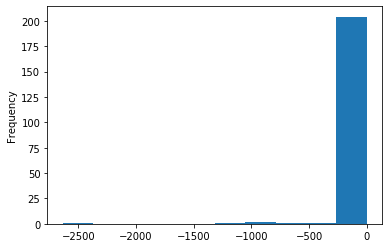

In [22]:
dmdts.dmdt_min.plot.hist()

### Selection criterior: dmdt_min - dmdt_error < threshold (e.g. -0.5 mag / day) and dt > 0.5 (we don't trust those)

In [23]:
# select objects that rise faster than this value in some band
threshold = -0.5 # mag / day
oids_dmdt = dmdts.loc[(dmdts.dmdt_comp < threshold) & (dmdts.dt > 0.5)].index.unique().tolist()
print(len(oids_dmdt))
print(oids_dmdt)

46
['ZTF20abpanuk', 'ZTF20abpcbbt', 'ZTF20abpbhea', 'ZTF20abpclxf', 'ZTF20abpcnlf', 'ZTF20abpcqpa', 'ZTF20abpdmwa', 'ZTF20abpgkpl', 'ZTF20abpgnos', 'ZTF20abpgpwr', 'ZTF19abgyrou', 'ZTF20abpmvhh', 'ZTF20abpnamh', 'ZTF20abpnjne', 'ZTF20abpnljo', 'ZTF20abpnnki', 'ZTF20abpnxds', 'ZTF20abpohsy', 'ZTF20abpoypq', 'ZTF20abptgdl', 'ZTF20abptgqj', 'ZTF20abqagtz', 'ZTF20abpnjlz', 'ZTF20abpobfs', 'ZTF20abpofst', 'ZTF20abprpeh', 'ZTF20abpshxl', 'ZTF20abptjgb', 'ZTF20abptxls', 'ZTF20abpxgbp', 'ZTF20abpxmig', 'ZTF20abpyzfa', 'ZTF20abqaofr', 'ZTF20abqcakm', 'ZTF20abqeayz', 'ZTF20abqbzuv', 'ZTF20abqdkne', 'ZTF20abqbefg', 'ZTF20abqbofq', 'ZTF20abqegnn', 'ZTF20abqgtqf', 'ZTF20abqhdmt', 'ZTF20abqhrpa', 'ZTF20abqhrpd', 'ZTF20abqhumo', 'ZTF20abqhxdy']


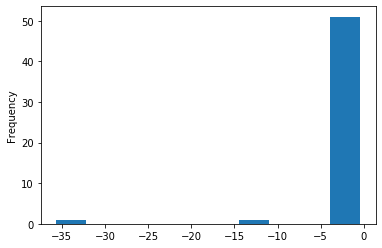

In [24]:
dmdts.loc[oids_dmdt].dmdt_min.plot.hist()

### get avros of final list and get drb field for additional filter

In [25]:
drb = {}
for oid in oids_dmdt:
    print(oid)
    
    # get candid of first stamp
    candid = detections.loc[detections.has_stamps].loc[oid].candid.min()

    params = {"oid": oid, "candid": candid}
    url = "http://avro.alerce.online"
    r = requests.get(url = "%s/get_avro_info" % url, params = params)
    response = r.json()
    
    drb_val = response["candidate"]["drb"]
    if drb_val >= 0.5:
        drb[oid] = drb_val

sn["drb"] = pd.Series(data = list(drb.values()), index = list(drb.keys()))

ZTF20abpanuk
ZTF20abpcbbt
ZTF20abpbhea
ZTF20abpclxf
ZTF20abpcnlf
ZTF20abpcqpa
ZTF20abpdmwa
ZTF20abpgkpl
ZTF20abpgnos
ZTF20abpgpwr
ZTF19abgyrou
ZTF20abpmvhh
ZTF20abpnamh
ZTF20abpnjne
ZTF20abpnljo
ZTF20abpnnki
ZTF20abpnxds
ZTF20abpohsy
ZTF20abpoypq
ZTF20abptgdl
ZTF20abptgqj
ZTF20abqagtz
ZTF20abpnjlz
ZTF20abpobfs
ZTF20abpofst
ZTF20abprpeh
ZTF20abpshxl
ZTF20abptjgb
ZTF20abptxls
ZTF20abpxgbp
ZTF20abpxmig
ZTF20abpyzfa
ZTF20abqaofr
ZTF20abqcakm
ZTF20abqeayz
ZTF20abqbzuv
ZTF20abqdkne
ZTF20abqbefg
ZTF20abqbofq
ZTF20abqegnn
ZTF20abqgtqf
ZTF20abqhdmt
ZTF20abqhrpa
ZTF20abqhrpd
ZTF20abqhumo
ZTF20abqhxdy


Text(0, 0.5, 'sn_prob')

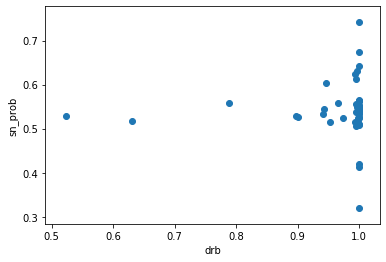

In [26]:
fig, ax = plt.subplots()
ax.scatter(sn.drb, sn.sn_prob)
ax.set_xlabel("drb")
ax.set_ylabel("sn_prob")

### Do oid list including drb

In [27]:
oids = list(drb.keys())
print(len(oids))
print(oids)

41
['ZTF20abpanuk', 'ZTF20abpcbbt', 'ZTF20abpbhea', 'ZTF20abpclxf', 'ZTF20abpcnlf', 'ZTF20abpcqpa', 'ZTF20abpgkpl', 'ZTF20abpgnos', 'ZTF20abpgpwr', 'ZTF20abpmvhh', 'ZTF20abpnamh', 'ZTF20abpnjne', 'ZTF20abpnljo', 'ZTF20abpnnki', 'ZTF20abpnxds', 'ZTF20abpohsy', 'ZTF20abpoypq', 'ZTF20abqagtz', 'ZTF20abpnjlz', 'ZTF20abpobfs', 'ZTF20abpofst', 'ZTF20abprpeh', 'ZTF20abptjgb', 'ZTF20abptxls', 'ZTF20abpxgbp', 'ZTF20abpxmig', 'ZTF20abpyzfa', 'ZTF20abqaofr', 'ZTF20abqcakm', 'ZTF20abqeayz', 'ZTF20abqbzuv', 'ZTF20abqdkne', 'ZTF20abqbefg', 'ZTF20abqbofq', 'ZTF20abqegnn', 'ZTF20abqgtqf', 'ZTF20abqhdmt', 'ZTF20abqhrpa', 'ZTF20abqhrpd', 'ZTF20abqhumo', 'ZTF20abqhxdy']


# Show summary of all tables

In [28]:
sn.loc[oids]

,meanra,meandec,firstmjd,nobs,classearly,pclassearly,sn_prob,vs_prob,agn_prob,asteroid_prob,bogus_prob,drb
ZTF20abpanuk,297.410514,50.932758,59057.337396,1,19,0.525145,0.525145,0.082884,0.086144,0.246798,0.059028,0.999960
ZTF20abpcbbt,334.033534,62.324965,59057.385324,2,19,0.544502,0.544502,0.081028,0.071121,0.224927,0.078422,0.943147
ZTF20abpbhea,301.131180,25.310637,59057.354502,1,19,0.510834,0.510834,0.086898,0.081483,0.189879,0.130905,0.999726
ZTF20abpclxf,328.442104,34.672369,59057.374271,1,19,0.549557,0.549557,0.079508,0.068263,0.249546,0.053126,0.999981
ZTF20abpcnlf,327.222442,28.794492,59057.369572,1,19,0.565355,0.565355,0.088005,0.080903,0.189193,0.076545,0.999929
ZTF20abpcqpa,23.510570,57.843415,59057.469167,1,19,0.558776,0.558776,0.090368,0.092929,0.108007,0.149921,0.965801
ZTF20abpgkpl,280.900485,37.946912,59059.299167,1,19,0.540918,0.540918,0.091337,0.082143,0.178839,0.106763,1.000000
ZTF20abpgnos,312.104921,29.751343,59059.324456,45,19,0.563039,0.563039,0.084431,0.075594,0.191441,0.085494,1.000000
ZTF20abpgpwr,320.951873,33.473752,59059.330544,7,19,0.419109,0.419109,0.104810,0.095189,0.304899,0.075993,1.000000
ZTF20abpmvhh,9.659630,54.567265,59060.437222,1,19,0.524649,0.524649,0.083021,0.072605,0.254245,0.065480,0.973124


In [29]:
detections.loc[oids]

,candid,sgscore1,distpsnr1,rb,fid,mjd,magpsf,sigmapsf,has_stamps
oid,,,,,,,,,
ZTF20abpanuk,1303337394815015020,0.007292,3.466689,0.561429,2,59057.337396,19.336630,0.174902,True
ZTF20abpcbbt,1303385323515015036,0.929235,2.174400,0.678571,1,59057.385324,19.807884,0.156032,True
ZTF20abpcbbt,1308332263515015012,0.929235,2.399888,0.761429,2,59062.332268,19.393454,0.147738,True
ZTF20abpbhea,1303354502115015046,0.821167,3.626487,0.562857,2,59057.354502,19.857540,0.191459,True
ZTF20abpclxf,1303374274015015004,0.610298,9.858289,0.682857,2,59057.374271,19.782272,0.123121,True
ZTF20abpcnlf,1303369575115015002,0.021125,5.783444,0.621429,2,59057.369572,19.571169,0.145532,True
ZTF20abpcqpa,1303469164815015014,0.756149,1.053951,0.527143,2,59057.469167,19.117941,0.167143,True
ZTF20abpgkpl,1305299160115015016,0.995833,2.020184,0.914286,1,59059.299167,19.208578,0.112699,True
ZTF20abpgnos,1305324454815015002,0.110119,0.312295,0.738571,2,59059.324456,19.272173,0.145361,True


In [30]:
non_detections.loc[oids]

,mjd,diffmaglim,fid
oid,,,
ZTF20abpanuk,59052.388854,20.711800,2
ZTF20abpanuk,59027.362974,20.691700,1
ZTF20abpanuk,59027.387940,20.679501,2
ZTF20abpanuk,59028.466516,20.358101,2
ZTF20abpanuk,59030.390961,20.694799,1
ZTF20abpanuk,59031.450579,20.343500,2
ZTF20abpanuk,59032.354224,20.277100,2
ZTF20abpanuk,59033.347442,20.089600,2
ZTF20abpanuk,59033.458125,20.247299,1


In [31]:
dmdts.loc[oids]

,dmdt_min,dmdt_error,dmdt_comp,dt,fid,Flag
ZTF20abpanuk,-1.323376,0.184907,-1.138469,0.945891,2,False
ZTF20abpcbbt,-1.074965,0.160427,-0.914537,0.972604,1,False
ZTF20abpcbbt,-35.670050,5.848662,-29.821388,0.026678,2,True
ZTF20abpbhea,-0.900559,0.187707,-0.712852,1.019988,2,False
ZTF20abpclxf,-0.607558,0.061368,-0.546190,2.006273,2,False
ZTF20abpcnlf,-1.047002,0.146945,-0.900057,0.990382,2,False
ZTF20abpcqpa,-1.304602,0.170467,-1.134135,0.980498,2,False
ZTF20abpgkpl,-0.546224,0.037290,-0.508934,3.022245,1,False
ZTF20abpgnos,-0.931608,0.010554,-0.921054,3.913912,1,False
ZTF20abpgnos,-1.166061,0.015169,-1.150892,2.973183,2,False


### Additional test: get galactic and ecliptic coordinates, also extinction in the direction of the object. If extinction too large, probably not a SN. If galactic or ecliptic latitude too small, probably variable star or asteroid, respectively

In [32]:
from astroquery.irsa_dust import IrsaDust
import astropy.coordinates as coord
import astropy.units as u

In [33]:
ecl_lat = {}
gal_lat = {}
gal_A_g = {}

for oid in oids:

    print(oid)
    ra = sn.loc[oid].meanra
    dec = sn.loc[oid].meandec
    coo = coord.SkyCoord(ra, dec, unit='deg', frame='fk5')    

    # ecliptic coordinates (input is hours, degrees)
    ecl_lat[oid] = np.rad2deg(ephem.Ecliptic(ephem.Equatorial('%s' % (ra / 15.), '%s' % dec, epoch=ephem.J2000)).lat)
    
    # galactic latitude
    gal_lat[oid] = np.rad2deg(ephem.Galactic(ephem.Equatorial('%s' % (ra / 15.), '%s' % dec, epoch=ephem.J2000)).lat)

    # Galactic extinction (use SFD = D.J. Schlegel, D.P. Finkbeiner, & M. Davis (1998, ApJ, 500, 525))
    table = IrsaDust.get_extinction_table(coo)
    gal_A_g[oid] = float(table[table["Filter_name"] == "SDSS g"]["A_SFD"])

ZTF20abpanuk
ZTF20abpcbbt
ZTF20abpbhea
ZTF20abpclxf
ZTF20abpcnlf
ZTF20abpcqpa
ZTF20abpgkpl
ZTF20abpgnos
ZTF20abpgpwr
ZTF20abpmvhh
ZTF20abpnamh
ZTF20abpnjne
ZTF20abpnljo
ZTF20abpnnki
ZTF20abpnxds
ZTF20abpohsy
ZTF20abpoypq
ZTF20abqagtz
ZTF20abpnjlz
ZTF20abpobfs
ZTF20abpofst
ZTF20abprpeh
ZTF20abptjgb
ZTF20abptxls
ZTF20abpxgbp
ZTF20abpxmig
ZTF20abpyzfa
ZTF20abqaofr
ZTF20abqcakm
ZTF20abqeayz
ZTF20abqbzuv
ZTF20abqdkne
ZTF20abqbefg
ZTF20abqbofq
ZTF20abqegnn
ZTF20abqgtqf
ZTF20abqhdmt
ZTF20abqhrpa
ZTF20abqhrpd
ZTF20abqhumo
ZTF20abqhxdy


In [34]:
sn_final = pd.concat([sn.loc[oids], pd.DataFrame.from_dict({'ecl_lat': ecl_lat, 'gal_lat': gal_lat, 'gal_A_g': gal_A_g})], axis=1, sort=False)
sn_final

,meanra,meandec,firstmjd,nobs,classearly,pclassearly,sn_prob,vs_prob,agn_prob,asteroid_prob,bogus_prob,drb,ecl_lat,gal_lat,gal_A_g
ZTF20abpanuk,297.410514,50.932758,59057.337396,1,19,0.525145,0.525145,0.082884,0.086144,0.246798,0.059028,0.999960,69.209786,12.304517,0.633
ZTF20abpcbbt,334.033534,62.324965,59057.385324,2,19,0.544502,0.544502,0.081028,0.071121,0.224927,0.078422,0.943147,63.304978,4.691304,4.183
ZTF20abpbhea,301.131180,25.310637,59057.354502,1,19,0.510834,0.510834,0.086898,0.081483,0.189879,0.130905,0.999726,44.431231,-3.284915,6.154
ZTF20abpclxf,328.442104,34.672369,59057.374271,1,19,0.549557,0.549557,0.079508,0.068263,0.249546,0.053126,0.999981,43.880098,-15.271682,0.762
ZTF20abpcnlf,327.222442,28.794492,59057.369572,1,19,0.565355,0.565355,0.088005,0.080903,0.189193,0.076545,0.999929,39.097657,-19.008247,0.322
ZTF20abpcqpa,23.510570,57.843415,59057.469167,1,19,0.558776,0.558776,0.090368,0.092929,0.108007,0.149921,0.965801,43.811018,-4.559095,2.058
ZTF20abpgkpl,280.900485,37.946912,59059.299167,1,19,0.540918,0.540918,0.091337,0.082143,0.178839,0.106763,1.000000,60.716245,17.721471,0.267
ZTF20abpgnos,312.104921,29.751343,59059.324456,45,19,0.563039,0.563039,0.084431,0.075594,0.191441,0.085494,1.000000,45.357596,-8.697427,1.276
ZTF20abpgpwr,320.951873,33.473752,59059.330544,7,19,0.419109,0.419109,0.104810,0.095189,0.304899,0.075993,1.000000,45.648737,-11.916933,0.562
ZTF20abpmvhh,9.659630,54.567265,59060.437222,1,19,0.524649,0.524649,0.083021,0.072605,0.254245,0.065480,0.973124,45.142740,-8.257909,1.509


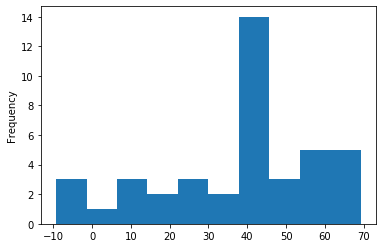

In [35]:
sn_final.ecl_lat.plot.hist()

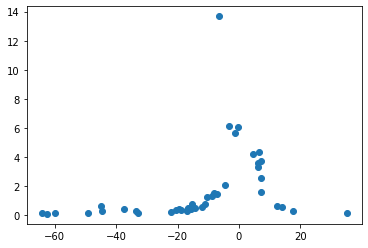

In [36]:
fig, ax = plt.subplots()
ax.scatter(sn_final.gal_lat, sn_final.gal_A_g)

### remove everything with |ecliptic latitude| below 20 unless it has more than one detection, and with galactic or ecliptic latitude below |20| or A_g > 1

In [37]:
mask = ((sn_final.nobs > 1) | (sn_final.ecl_lat > 20)) & (sn_final.gal_lat > 20) & (sn_final.gal_A_g < 1)

In [38]:
sn_final.loc[mask]

,meanra,meandec,firstmjd,nobs,classearly,pclassearly,sn_prob,vs_prob,agn_prob,asteroid_prob,bogus_prob,drb,ecl_lat,gal_lat,gal_A_g
ZTF20abqbzuv,259.113097,43.342743,59065.217639,2,19,0.611903,0.611903,0.103325,0.094727,0.077492,0.112553,0.994737,66.036607,35.002442,0.115


# Plot stamps of final list

In [39]:
for oid in sn_final.loc[mask].index:
    display(HTML("<a href='http://alerce.online/object/%s'> %s <a>" % (oid, oid)))
    display(pd.DataFrame(sn_final.loc[oid]).transpose())
    client.plot_stamp(oid)
    sn.loc[oid]

,meanra,meandec,firstmjd,nobs,classearly,pclassearly,sn_prob,vs_prob,agn_prob,asteroid_prob,bogus_prob,drb,ecl_lat,gal_lat,gal_A_g
ZTF20abqbzuv,259.113097,43.342743,59065.217639,2.0,19.0,0.611903,0.611903,0.103325,0.094727,0.077492,0.112553,0.994737,66.036607,35.002442,0.115


# Plot distribution of dmdt

In [40]:
sn_final.head()

,meanra,meandec,firstmjd,nobs,classearly,pclassearly,sn_prob,vs_prob,agn_prob,asteroid_prob,bogus_prob,drb,ecl_lat,gal_lat,gal_A_g
ZTF20abpanuk,297.410514,50.932758,59057.337396,1,19,0.525145,0.525145,0.082884,0.086144,0.246798,0.059028,0.999960,69.209786,12.304517,0.633
ZTF20abpcbbt,334.033534,62.324965,59057.385324,2,19,0.544502,0.544502,0.081028,0.071121,0.224927,0.078422,0.943147,63.304978,4.691304,4.183
ZTF20abpbhea,301.131180,25.310637,59057.354502,1,19,0.510834,0.510834,0.086898,0.081483,0.189879,0.130905,0.999726,44.431231,-3.284915,6.154
ZTF20abpclxf,328.442104,34.672369,59057.374271,1,19,0.549557,0.549557,0.079508,0.068263,0.249546,0.053126,0.999981,43.880098,-15.271682,0.762
ZTF20abpcnlf,327.222442,28.794492,59057.369572,1,19,0.565355,0.565355,0.088005,0.080903,0.189193,0.076545,0.999929,39.097657,-19.008247,0.322


# Plot distribution in the sky

Text(0, 0.5, 'N')

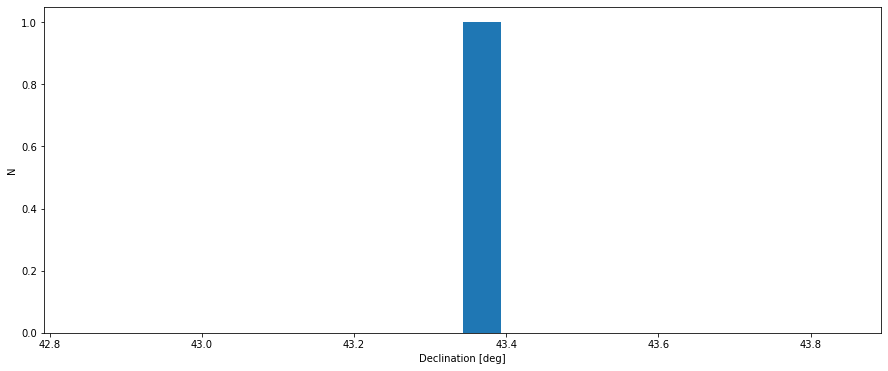

In [41]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.hist(sn_final.loc[mask].meandec, bins=20);
ax.set_xlabel("Declination [deg]")
ax.set_ylabel("N")

Text(0, 0.5, 'N')

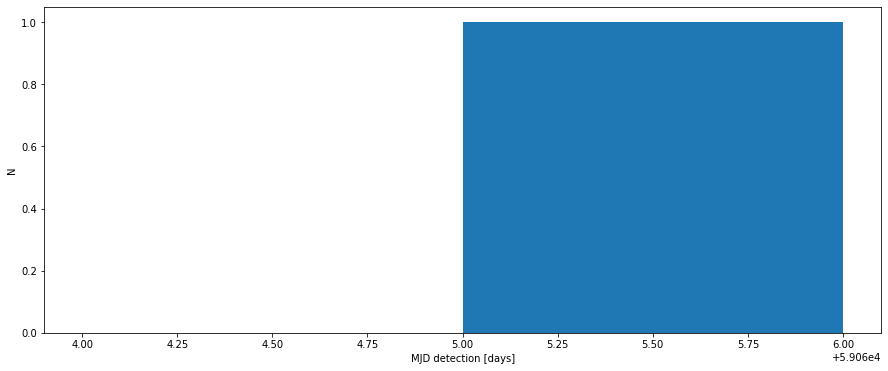

In [42]:
fig, ax = plt.subplots(figsize=(15, 6))
mjd_i = int(sn_final.loc[mask].firstmjd.min() - 1)
mjd_f = int(sn_final.loc[mask].firstmjd.max() + 1)
ax.hist(sn_final.loc[mask].firstmjd, bins=np.linspace(mjd_i, mjd_f, mjd_f - mjd_i + 1));
ax.set_xlabel("MJD detection [days]")
ax.set_ylabel("N")

# Spatial distribution

Text(0, 0.5, 'DEC')

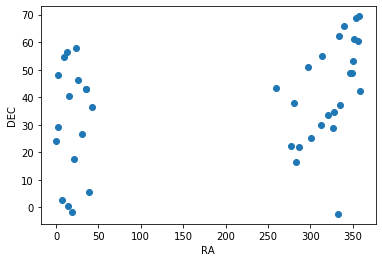

In [43]:
fig, ax = plt.subplots()
ax.scatter(sn_final.meanra,sn_final.meandec)
ax.set_xlabel("RA")
ax.set_ylabel("DEC")

# This is useful if there were lots of candidates to plot

In [44]:
import datashader as ds
import datashader.transfer_functions as tf
import bokeh.plotting as bp
from datashader.bokeh_ext import InteractiveImage

In [45]:
bp.output_notebook()
p = bp.figure(tools='pan,wheel_zoom,reset', x_range=(0,360), y_range=(-90,90), plot_width=800, plot_height=500)

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(sn_final.loc[mask], 'meanra', 'meandec', ds.count())
    img = tf.shade(agg, cmap=viridis)
    return tf.spread(img)

InteractiveImage(p, image_callback)

Loading BokehJS ...

/home/fforster/anaconda3/lib/python3.6/site-packages/datashader/transfer_functions.py:231: RuntimeWarning: invalid value encountered in true_divide
  img = cmap((data - span[0])/(span[1] - span[0]), bytes=True)
/home/fforster/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
